# Introduction 

This notebook is designed to solve a binary classification problem using Python. In this competition, we are asked to predict the US-household level income as High or Low. The data on which we worked is taken from the US Census Bureau and it results from a survey held in 2020-2021 and with the participation of US residents who provided their own demographic information.

### About the data

For this practice problem, we have been given two CSV files: train and test. The train file will be used for training the model. It contains all the independent variables and the target variable `high_income`.

The test file contains all the predictors, but not the target variable. We will apply the model to predict the target variable for the test data. To evaluate our models, we have to submit these predictions on the Public Leaderboard on Kaggle which score our submission by indicating the accuracy of our predicted target value. It is important to notice that the score provided is evaluated on 30% of the test data (randomly chosen beforehand). Hence, during the competition, we didn't have a total evaluation of our accuracy. This means that the model providing the best score is not necessarily the best one to choose.

### Procedure

First we explore the dataset. 
Then we built our best predictive model: "X Gradient Boosting". After a description of this model we compare it with the following models: kNN, LDA, QDA, logistic, SVC linear.
    
For each model we follow these steps:
1. Preprocessing
1. Hyperparameter selection with CV
1. Fit the model with selected hyperparameters
1. Diagnostic of the fitted model
1. k-fold cross-validation on the validation set to address the accuracy of the model

While runningh the code, the result of the cross validation, the  best parameters and the fitted model  are saved as well as the figures of the individual diagnostic and the comparision between model.

- To load these files instead of running the codes, set `load_bool = 1`
- To skip running the hyperparameter selection with CV, set `perform_CV_bool = 0`
- To save the results, set `save_bool = 1`

In [43]:
load_bool = 0
perform_CV_bool = 1
save_bool = 1

### Structure of the notebook
1. Preparation
    - Import library 
    - Import data
    - Exploration of the data set
1. Build functions
    - Pipeline and fit 
    - Hyperparameter selection with CV
    - Fit the model with selected hyperparameters
    - Diagnostic of the fitted model
    - Global function
1. Set efficient models
    - XGradient Boosting 
    - Neural network
1. Comparison with other models
1. Conclusion and Kaggle soumission

# I. Preparation

## Import library

In [44]:
import os
import re  # to remove undesired symbole in the name of the predictors
import sys
import time
from itertools import permutations
import missingno as msno
import joblib  # to save and load the models

# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Preprocessing and pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.impute import SimpleImputer 
import sklearn
sys.modules["sklearn.neighbors.base"] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.compose import ColumnTransformer  # to transform object types

# Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.kernel_approximation import RBFSampler

import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD
from keras_sequential_ascii import keras2ascii

# CV
from sklearn.model_selection import GridSearchCV,KFold,RandomizedSearchCV,cross_val_score,train_test_split

# Mesure
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ClassificationReport, ROCAUC

# Adress compatibility of the libraries
from platform import python_version
import matplotlib

print("Python version:", python_version())
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)
print("Sklearn version:", sklearn.__version__)
del matplotlib # to not create conflicts

"""
Python version: 3.9.10
Numpy version: 1.22.3
Matplotlib version: 3.5.1
Pandas version: 1.4.1
Seaborn version: 0.11.2
Sklearn version: 1.1.0
"""

Python version: 3.9.10
Numpy version: 1.22.3
Matplotlib version: 3.5.1
Pandas version: 1.4.1
Seaborn version: 0.11.2
Sklearn version: 1.1.0


'\nPython version: 3.9.10\nNumpy version: 1.22.3\nMatplotlib version: 3.5.1\nPandas version: 1.4.1\nSeaborn version: 0.11.2\nSklearn version: 1.1.0\n'

## Import dataset
We can encode the categorical variables with `pandas.get_dummies`.
Others ways to address this problem have been explored and can be flexibly chosen thanks to the functions of the notebook. However, after several attempts, we choose to go for this solution. 
In order to encode all the possible labels,`pandas.get_dummies` is applied to `train`and `test`dataset  concatenated.

In [45]:
# Import the data
f = pd.read_csv("train.csv")
X_test_data = pd.read_csv("test.csv")

# Split predictors and output
X = f.drop(["high_income"], axis="columns")
y = f["high_income"]

# Encode categorical variables
dummies_bool = 1
if dummies_bool == 1:
    # concatenate
    X_concat = pd.concat([X, X_test_data], axis=0)
    
    # encode with dummies
    X_concat = pd.get_dummies(X_concat, drop_first=True)

    # remove unsupported symboles
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    X_concat.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_concat.columns.values]

    # split
    X = X_concat.iloc[: X.shape[0], :]
    X_test_data = X_concat.iloc[X.shape[0] :, :]

# Split the data between train, test and validation set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=None)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=None)

# Already set the folds
n_splits  = 6
kfold = KFold(n_splits=n_splits)

In [46]:
#set parameters for the plots
sns.set() # Setting seaborn as default style even if use only matplotlib
sns.set_theme(style="whitegrid")

# set the seed
seed = 2

## Exploration

The first step in getting familiar with the data set is to determine which type of features we are dealing with. By exploring the data we find that it contains 28 categorical variables and 13 numerical variables (7 integer and 6 float) including the target one `High income`

In [47]:
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54607 entries, 0 to 54606
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                54607 non-null  int64  
 1   occ_code_level2   54607 non-null  int64  
 2   age               29892 non-null  float64
 3   stock_dividends   29720 non-null  float64
 4   mig_chg_msa       26888 non-null  object 
 5   tax_filer_stat    29121 non-null  object 
 6   det_hh_summ       54607 non-null  object 
 7   mig_prev_sunbelt  26888 non-null  object 
 8   hisp_origin       54377 non-null  object 
 9   education         29786 non-null  object 
 10  wage_per_hour     29712 non-null  float64
 11  capital_losses    29850 non-null  float64
 12  vet_question      54607 non-null  object 
 13  own_or_self       54607 non-null  int64  
 14  country_self      53532 non-null  object 
 15  mig_move_reg      26888 non-null  object 
 16  high_income       54607 non-null  int64 

### Percentage high income

percentage of high income: 0.307469738311938


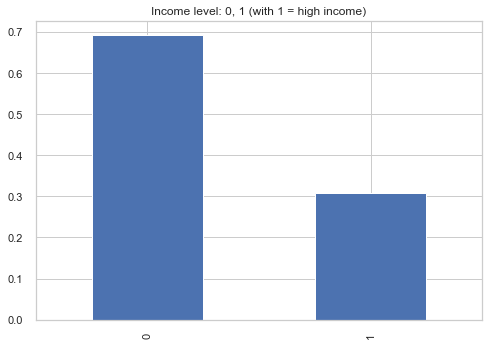

In [48]:
f["high_income"].value_counts(normalize=True).plot.bar(title = 'Income level: 0, 1 (with 1 = high income)')
print('percentage of high income: ' + str(sum(f["high_income"])/len(f)))

The target variable is binary and numerical. It indicates "1" if the income level is high and "0" if it is low. From the training set, about 30% of the target value has a high income level. Such information is interesting when predicting from the test set and we can consider it as a reference or a rule of thumb to evaluate our models results at first sight. For example, if we get a result with about 70% of high income we can say that this result over evaluate the level of high income.

### Levels of the categorical variables 

In [52]:
level=pd.DataFrame(f.select_dtypes(exclude="number").select_dtypes([object]).nunique())
level.rename( columns={0 :'COUNTS'}, inplace=True )
level.sort_values(by= ['COUNTS'], ascending=True,inplace=True)
level

,COUNTS
sex,2
mig_same,3
union_member,3
mig_prev_sunbelt,3
vet_question,3
hs_college,3
fam_under_18,5
citizenship,5
race,5
unemp_reason,6


### Corelation matrix 

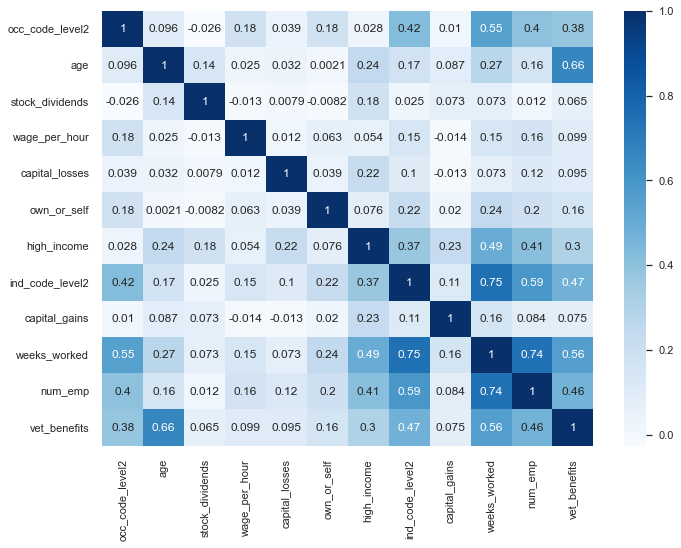

In [49]:
f.drop("id",axis=1,inplace=True)# Delete the useless 'id' column
corr = f.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Blues",annot=True)
plt.show()

Since feature "id" corresponds to the index of each row and hence it is useless in the prediction we decide to delete it to reduce the size of the data.

To have an insight of the relationships between numerical variables we plot the correlation matrix as a heatmap which is the best way to get a quick overview of our features relationships.

At first sight, there are two blues-colored squares that get our attention. The first one refers to the 'ind_code_level2' and '1weeks_worked' variables, and the second one refers to the 'num_emp' variables. Both cases show how significant the correlation is between these variables. Actually, this correlation is so strong that it can indicate a situation of multicollinearity. Although, multicolinearity occurs we decide to keep all the features to not lose information.

Another thing that get our attention is the 'High income' correlations. We can see that it has a moderate correlation with "weeks_worked" and "num_emp" variables. In fact "num_emp" seems to represent the number of other family members who are self employed and "weeks_worked" stands for the number of weeks worked in the year. Hence it seems obvious that these two variables can increase the incomes.

### Variance Inflation Factor

In [50]:
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    for feature in features:
        # extract all the other features we will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                       
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
        # return VIF DataFrame
    return pd.DataFrame({'VIF': vif}).style.background_gradient(cmap='Blues')

imputer = MissForest()
num_data = f.select_dtypes(include=[np.number])
numerical_data= imputer.fit_transform(num_data)
numerical_data= pd.DataFrame(numerical_data, columns=num_data.columns)
calculate_vif(df=numerical_data, features=numerical_data.columns)

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

Iteration: 0


/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

Iteration: 1


/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

Iteration: 2


/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

Iteration: 3


/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

Iteration: 4


/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

Iteration: 5


/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3

Iteration: 6


,VIF
age,2.391576
capital_gains,1.496931
capital_losses,1.395224
high_income,1.819921
ind_code_level2,2.328217
num_emp,2.339443
occ_code_level2,1.680870
own_or_self,1.081462
stock_dividends,2.973489
vet_benefits,3.208105


When training a machine learning model, it is important that during the data processing stage we detect the features exhibiting multicollinearity. To do so, we use a method known as VIF (Variance Inflation Factor) which determine the strength of the correlation between the different variables.

After implementing the VIF calculation, we obtain this gradient table which indicates that the features are moderately correlated since VIF values don't exceed 5. Hence, we can keep the unchanged data to train our models.

### Address Nan values 

<AxesSubplot:>

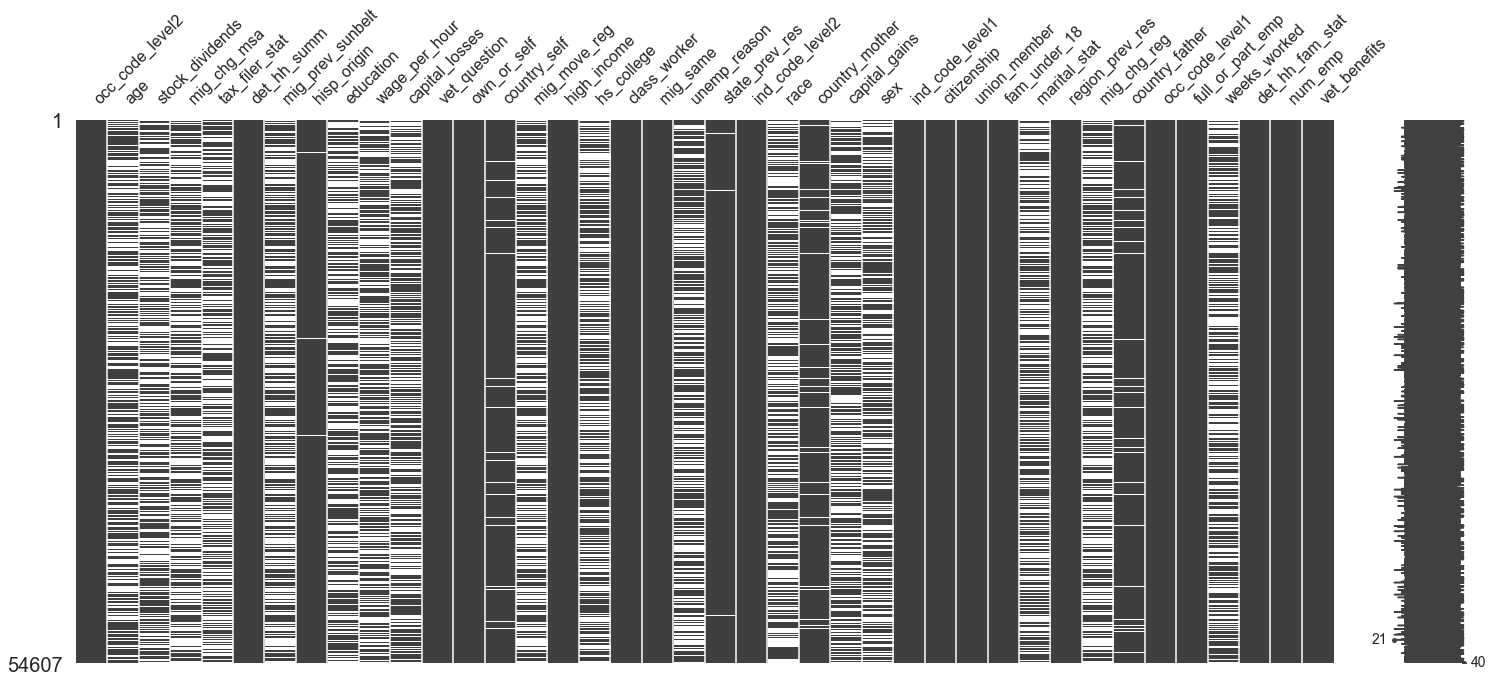

In [53]:
%matplotlib inline
msno.matrix(f)

We use the matrix plot from the missing Python library to identify and visualize missing data. It provides a color fill for each column. When data is present, the plot is shaded in grey, and when it is absent the plot is displayed in white.

Most of the features contain missing values. The target variable `high_income` doesn't contain missing data.

It might be helpful to see what percentage of the values in our dataset were missing to give us a better sense of the scale of this problem:

In [54]:
# how many total missing values do we have?
total_cells = np.product(f.shape)
# get the number of missing data points per column
missing_values_count = f.isnull().sum()
total_missing = missing_values_count.sum()
# percent of data that is missing
(total_missing/total_cells) * 100

20.120726280513487

About 20% of the cells in this dataset are empty! In the next step, we're going to take a closer look at some of the columns with missing values and try to figure out what might be going on with them.

In [55]:
#missing data
total = f.isnull().sum().sort_values(ascending=False)
percent = (f.isnull().sum()/f.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(22)

,Total,Percent
mig_move_reg,27719,0.507609
mig_prev_sunbelt,27719,0.507609
mig_chg_reg,27719,0.507609
mig_chg_msa,27719,0.507609
tax_filer_stat,25486,0.466717
marital_stat,25481,0.466625
unemp_reason,24965,0.457176
wage_per_hour,24895,0.455894
capital_gains,24891,0.455821
stock_dividends,24887,0.455747


In this table, we display only the column names containing missing values. We sort them in descending order by putting on the top features which contain the highest percentage of missing values. As we can notice, 18 features of 22 are quite half empty. Among them, there is the "weeks_worked" column which is quite correlated to the target value. If we look closely at these features, we can say that they provide sensitive information about the wealth of each person or and hence it might be categorized as Missing, not at Random Data.

So to deal with these Missing values, we decide not to remove them in order to not lose too much information due to their consequent proportion in the data set and also in order to avoid introducing bias. Instead, we decided to use several method imputations such as replacing Nan with the mean or the median of the feature which can be applied to numerical variables. For the categorical features, we used the majority vote imputation method that consists in replacing the Nan with the most frequent level. These methods are simple and not computationally demanding but they artificially reduce variability in the data.
As our work has moved forward, we decided to use a more complex methods which are Hot Deck method and we used MissForest which fills in missing values based on values of examples that are similar or close. Hence this method get more information and introduce variability in the data but it is computationally expensive.

### Distribution of the predictors and detection of outliers 

<Figure size 1368x864 with 0 Axes>

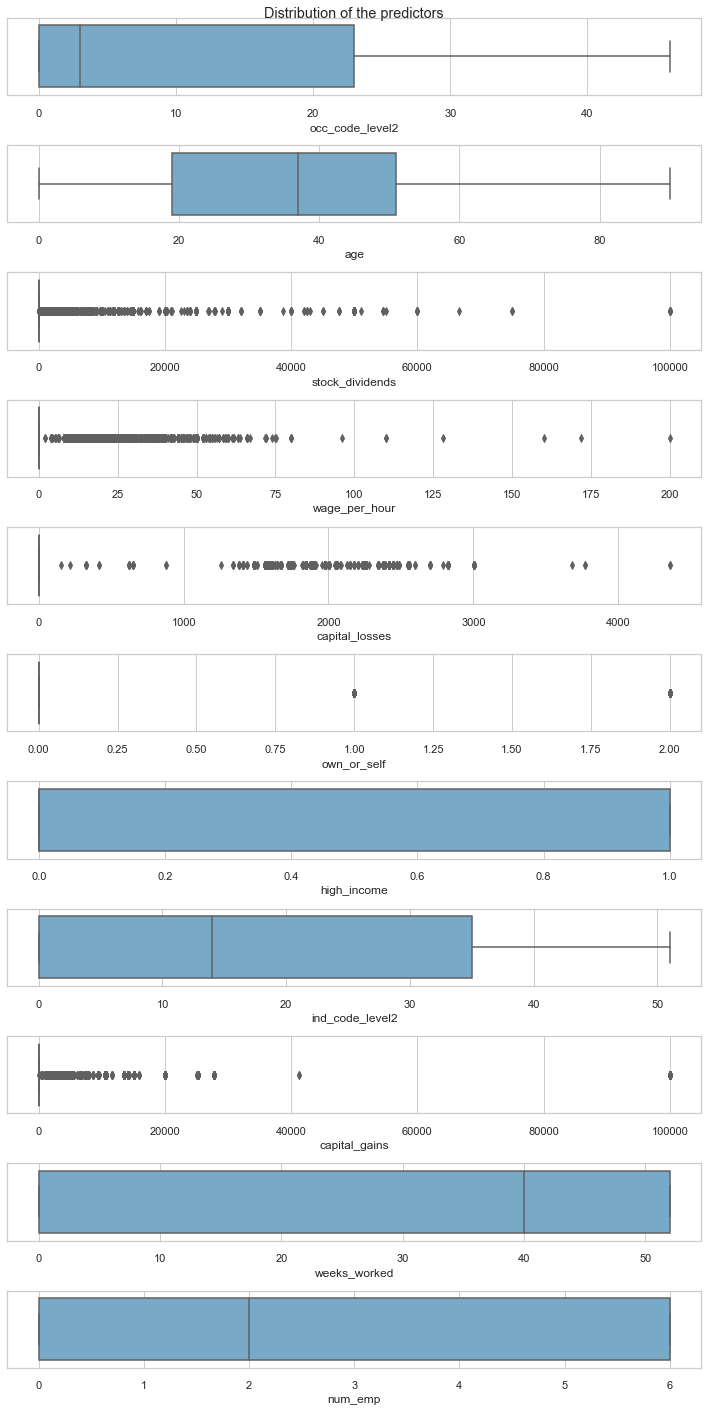

In [51]:
plt.figure(figsize=(19,12))
fig, axes = plt.subplots(11,1, figsize=(10, 20), sharey=False)
fig.suptitle('Distribution of the predictors')
for i in range (11):
    sns.boxplot(x=f[num_data.columns[i]], data=f ,palette = 'Blues', ax = axes[i])
    axes[i].set_title("")
    plt.tight_layout()

In order to choose whether to fill Nan values with Mean, Median, or Mode, one can check the presence of outliers. If the data is prone to outliers, which means it contains a good amount of outliers, it is not appropriate to choose Mean as it will implicitly contain information of outliers. It is better to choose Mode or Median in that case.

As we can see from the boxplots, the data contains outliers and so we exclude the mean method for imputation.

# II. Build functions

## 1.Pipeline and fit 

This function creates a pipeline that preprocesses the data and set a given model. It outputs also the transformed train, test, and validation set for further use.

Our dataset needs the following preprocessing:

- Numerical scaling: to address the outlier’s issues and make comparable the range of the predictors between one another.
- Missing values: to treat the missing values a simple way is to replace them either by the mean or the median for the numerical predictors and by the most frequent label for the categorical predictors. One can also apply MissForest, which is a very powerful imputer: “It can be used to impute continuous and/or categorical data including complex interactions and non-linear relations. It yields an out-of-bag (OOB) imputation error estimate without the need of a test set or elaborate cross-validation” [ documentation of MissForest ](https://rpubs.com/lmorgan95/MissForest)
- Categorical encoding: since some models are not able to handle categorical variables, we have to transform them into numbers.

Thanks to the flexibility of this function we test a lot a combination of these preprocessing steps. We choose the scale the numerical data with  `StandardScaler`. Since the VIF is not so high, we choose to use `pd.dummies` as the encoder. This encoding increases a lot the number of columns in an already very large dataset. Thus applying MissForest is no more possible. Instead, we choose to use "median" and "most frequent".

In [56]:
def set_pipe_model(X_train, X_test, X_val, model,
    numerical_scaler='StandardScaler',  #'MinMaxScaler'
    numerical_imputer='nothing',        # 'median', 'mean', 'MissForest'
    categorical_encoder='OneHotEncoder', # 'OrdinalEncoder'
    categorical_imputer='most frequent'):# 'MissForest', 'nothing'
    """
    input.
            X_train                   DataFrame       predictors of the training set
            X_test                    DataFrame       predictors of the test set
            X_val                     DataFrame       predictors of the validation set
            model                     Tuple           ("name of the model",sklearn function setting the model)
            numerical_scaler          String          choice of the numerical imputer                                                        
            categorical_encoder       String          choice of the categorical encoder
            categorical_imputer       String          choice of the categorical imputer


    output. 
           pipe_model                 Pipeline        model setted 
           X_train_transformed        DataFrame       predictors of the training set transformed
           X_test_transformed         DataFrame       predictors of the test set transformed
           X_val_transformed          DataFrame       predictors of the validation set transformed
    """

    # 1. Split the features according to their types: either numerical or categorical
    numerical_features = X_train.select_dtypes(include="number").columns.tolist()
    categorical_features = X_train.select_dtypes(exclude="number").columns.tolist()

    # 2. Set the pipeline to preprocess the numerical features: 
    # Scaling 
    if numerical_scaler == 'MinMaxScaler':
        numerical_scaler = ("numerical_scaler", MinMaxScaler())
        
    elif numerical_scaler == 'StandardScaler':
        numerical_scaler = ("numerical_scaler", StandardScaler())
        
    # Treatement of the NaN and set numeric_pipeline
    if numerical_imputer == 'nothing':  # nothing is done, used when set XGradient Boosting
        numeric_pipeline = Pipeline(steps=[numerical_scaler])
        
    elif numerical_imputer == 'median':
        numerical_imputer = ("numerical_imputer", SimpleImputer(strategy="median"))
        numeric_pipeline = Pipeline(steps=[numerical_imputer, numerical_scaler])
        
    elif numerical_imputer == 'mean':
        numerical_imputer = ("numerical_imputer", SimpleImputer(strategy="mean"))
        numeric_pipeline = Pipeline(steps=[numerical_imputer, numerical_scaler])
        
    elif numerical_imputer == 'MissForest':
        numerical_imputer = ("numerical_imputer", MissForest())
        numeric_pipeline = Pipeline(steps=[numerical_imputer, numerical_scaler])

    # 3. Set the pipeline to preprocess the categorical features: 
    # Categorical encoding 
    if categorical_encoder == 'OneHotEncoder':
        categorical_encoder = ("categorical_encoder",OneHotEncoder(handle_unknown="ignore", sparse=False))
                               
    elif categorical_encoder == 'OrdinalEncoder':
        categorical_encoder = ("categorical_encoder", OrdinalEncoder())
    
    # Treatement of the NaN and set categorical_pipeline
    if categorical_imputer == 'nothing':  # nothing is done
        categorical_pipeline = Pipeline(steps=[categorical_encoder])
                               
    elif categorical_imputer == 'MissForest':
        categorical_imputer = ("categorical_imputer", MissForest())
        categorical_pipeline = Pipeline(steps=[categorical_imputer, categorical_encoder])
                               
    elif categorical_imputer == 'most frequent':
        categorical_imputer = ("categorical_imputer",SimpleImputer(strategy="most_frequent"))
        categorical_pipeline = Pipeline(steps=[categorical_imputer, categorical_encoder])

    # 4. Put together the preprocessing of the numerical and categorical features
    full_processor = ColumnTransformer(transformers=[
            ("number", numeric_pipeline, numerical_features),
            ("category", categorical_pipeline, categorical_features)],
        n_jobs=-1)
                               
    # 5. Fit the preprocessing steps on the training set and transform on the training, test. and validation set                          
    X_train_transformed = full_processor.fit_transform(X_train)
    X_test_transformed = full_processor.transform(X_test)
    X_val_transformed = full_processor.transform(X_val)
    
    # 6. Create the pipeline including the preprocessing and the setting of the model
    pipe_model = Pipeline([("preprocess", full_processor),(model)], verbose=1)
                               
    return pipe_model, X_train_transformed, X_test_transformed,X_val_transformed

## 2. Hyperparameter selection with CV

This function performs cross-validation to find the best and 1 se-rule parameters for a given grid.
- It plots also for each hyperparameter the mean and standard deviation of the accuracy of each value of the grid. 
- Heatmaps of the mean accuracy of one hyperparameter against another can also be displayed.

In [57]:
def perform_CV(X_train,y_train,pipe_model,hyper_params,load_bool,save_bool,n_splits=5,se_rule=0,seed=seed):
    """
    input.
            X_train             DataFrame       predictors of the training set
            y_train             Series          high_income of the training set
            pipe_model          Pipeline        preprocessed model 
            hyper_params        dict            grid of hyperparameters
            load_bool           int             choice of loading the result of CV
            save_bool           int             choice of saving the result of CV
            n_splits            int             number of splits
            se_rule             int             choice of the paramters for the fitting of the model
                                                 0: choice of the best parameters
                                                 1: choice of the 1se parameters
            seed               int.             seed number fixed to have reproducibility
    output. 
           params              dict            hyperparamters selected by CV 
                                               and the se-rule if se_rule = 1
    """
    start_time = time.time()
    if load_bool:
        if type(pipe_model) == sklearn.pipeline.Pipeline:
            search = joblib.load("result_cv_"+str(pipe_model.steps[1][0])+".pkl")
        else:
            search = joblib.load("result_cv_"+str(type(pipe_model))[8:11]+".pkl")
    else:
        
        # 1. Define folds
        folds = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

        # 2. Define the cross validation object
        search = GridSearchCV(estimator=pipe_model,param_grid=hyper_params,scoring="accuracy",
                                  cv=folds,n_jobs=-1,verbose=5)
            
        # 3. Fit the cross validation object using the training set
        search.fit(X_train, y_train)
    
    # 4. Grab the mean and standard deviation scores for each value of the hyperparameters
    mean_scores = search.cv_results_["mean_test_score"]
    se_scores = search.cv_results_["std_test_score"] / np.sqrt(n_splits)

    # 5. Find best hyperparameters
    best_param = search.cv_results_["params"][np.argmax(mean_scores)]
    best_index = np.argmax(mean_scores)
    best_score = np.max(mean_scores)

    print("best.  Score: " + str(best_score) + " Parameters:")
    print(best_param)

    # 6. Find the 1se hyperparameters
    bool_candidat_1se = mean_scores >= mean_scores[best_index] - se_scores[best_index]
    candidat_1se_score = np.sum(list(map(abs,list(
                    search.cv_results_["params"][np.where(bool_candidat_1se)[0][0]].values()),)))
    best_1se_param_idx = np.where(bool_candidat_1se)[0][0]
    for i, x in enumerate(bool_candidat_1se):
        if x and candidat_1se_score > np.sum(
            list(map(abs, list(search.cv_results_["params"][i].values())))):
            best_1se_param_idx = i
    best_1se_param = search.cv_results_["params"][best_1se_param_idx]
    best_1se_score = mean_scores[best_1se_param_idx]

    print("best 1se. Score: " + str(best_1se_score) + " Parameters:")
    print(best_1se_param)
    
    print("--- %s seconds ---" % (time.time() - start_time))  
    
    # 7. For each hyperparameter, plot the  mean and standard deviation of the accuracy,
    # and the best and the 1-se hyperparameter
    if (type(pipe_model) != sklearn.pipeline.Pipeline) or (str(pipe_model.steps[1][0]) != 'RF'):
        param_sorted = [
            np.unique(pd.DataFrame(search.cv_results_).iloc[:, 4 + i])
            for i in range(len(hyper_params))]
        for idx, grid in enumerate(param_sorted):
            plt.figure(idx)
            mean_score_param = []
            se_score_param = []

            for param_value in grid:
                bool_same_param = (search.cv_results_[list(search.cv_results_.keys())[4 + idx]]== param_value)
                mean_score_param.append(
                    np.mean(search.cv_results_["mean_test_score"][bool_same_param]))
                se_score_param.append(
                    np.mean(search.cv_results_["std_test_score"][bool_same_param]))
            plt.errorbar(
                x=grid, y=mean_score_param, yerr=se_score_param, fmt="o", capsize=3)


            plt.axvline( 
                list(best_param.values())[idx], ls="dotted", color="grey"
            )  # vertical line at the parameter value yielding highest accuracty
            plt.axhline(
                best_score, ls="dotted", color="grey"
            )  # horizontal line at highest accuracy
            plt.axvline(
                list(best_1se_param.values())[idx], ls="dotted", color="green"
            )  # vertical line at the parameter corresponding to 1-se
            plt.axhline(
                best_1se_score, ls="dotted", color="green"
            )  # horizontal line at corresponding to 1-se parameter

            plt.title("CV Accuracy")
            plt.xlabel("hyperparam " + list(search.cv_results_.keys())[4 + idx])
            plt.ylabel("CV Accuracy")
            plt.show()
    
    # 8. plot heatmap
    # -only for the model XGradient Boosting-
    if type(pipe_model) != sklearn.pipeline.Pipeline:
        res = pd.DataFrame(search.cv_results_)
        fig, axes = plt.subplots(len(list( permutations( range(len(param_sorted)), 2 ))),1, figsize=(5, 20),constrained_layout=True)
        fig.suptitle('CV Accuracy')
        for count, idx in enumerate(list( permutations( range(len(param_sorted)), 2 ) )):
            #axes[count].set_title("")
            sns.heatmap(pd.pivot_table(res,values='mean_test_score', index=res.columns[4+idx[0]],columns=res.columns[4+idx[1]]),ax = axes[count],cmap='Blues',annot = True,fmt = ".3g")

          
    # set param and save if needed
    if se_rule:
        params = best_1se_param
    else:
        params = best_param
    #pipe_model.fit(X_train, y_train)

    if save_bool == 1:
        if type(pipe_model) == sklearn.pipeline.Pipeline:
            joblib.dump(search, "result_cv_"+str(pipe_model.steps[1][0])+".pkl")
            joblib.dump(params,"params_"+str(pipe_model.steps[1][0])+".json")
        else:
            joblib.dump(search, "result_cv_"+str(type(pipe_model))[8:11]+".pkl")
            joblib.dump(params,"params_"+str(type(pipe_model))[8:11]+".json")
            fig.savefig("CV_plot"+str(type(pipe_model))[8:11]+".jpg")
    return  params

## 3. Fit the model with selected hyperparameters

In [58]:
def fit_pipe_model(X_train, y_train, pipe_model,params,load_bool,save_bool):
    """
    Output model fitted on the set (X_train, y_train) with the parameters params
    """
    if load_bool:
        fitted_pipe_model = joblib.load("fitted_"+str(pipe_model.steps[1][0])+".json")
    else: 
        # perform fitting
        pipe_model.set_params(**params)
        fitted_pipe_model = pipe_model.fit(X_train, y_train)
        
    if save_bool:
        joblib.dump(fitted_pipe_model,"fitted_"+str(pipe_model.steps[1][0])+".json")
            
    return fitted_pipe_model

## 4. Diagnostic of the fitted model

This function performs a diagnostic of the fitted model: 

- It computes the accuracy of the training and test set and the absolute error.
- Using the Yellowbrick library, it plots the `ClassificationReport` ( i.e. the precision, recall, F1, and support scores)  as well as  "the Receiver Operating Characteristic”, “a visualization of  the tradeoff between the classifier’s sensitivity and specificity”
- It displays also the confusion matrix,  "a report showing how each of the test values predicted classes compare to their actual classes."

In [59]:
def model_diagnostic(X_train, y_train, X_test, y_test, pipe_model):
    # 1. Prediction
    
    # Predict on training
    y_pred_train = pipe_model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    print("Accuracy on training:", acc_train)

    # Predict on test
    y_pred_test = pipe_model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    print(" Accuracy on test:", acc_test)
    
    # 2. Visualization
    
    # Plot the Classification Report and ROCAUC
    fig, axes = plt.subplots(1,3,figsize=(13, 4))
    visualgrid = [ClassificationReport(pipe_model, ax=axes[1],cmap="Blues"),
        ROCAUC(pipe_model, ax=axes[2],binary=True),]
    for viz in visualgrid:
        viz.fit(X_train, y_train)
        viz.score(X_test, y_test)
        viz.finalize()
        
    # Plot the confusion matrix    
    cm = confusion_matrix(y_test, y_pred_test, normalize="true")
    conf_matrix = pd.DataFrame(data=cm, columns=["Predicted:0", "Predicted:1"], index=["Actual:0", "Actual:1"])
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', ax=axes[0]) 
    ax[0].set_title('Confusion matrix with prediction on the test set')
    plt.show()
    
    if save_bool:
        fig.savefig("diagnostic_"+str(pipe_model.steps[1][0])+".png")
    
    return abs(y_pred_train-y_train), acc_train, abs(y_pred_test-y_test), acc_test

## 5. Global function 

This function puts together the different steps needed to build and analyse a model. 

In [60]:
def model_pip_cv_fit(X_train, y_train,X_test, y_test,model ,hyper_params,load_bool,perform_CV_bool,save_bool,n_splits=5,seed=seed,
     numerical_scaler='StandardScaler', numerical_imputer='nothing', categorical_encoder='OneHotEncoder', categorical_imputer='most frequent'):
    
    # 1. Preprocessing
    pipe_model, X_train_transformed,X_test_transformed,X_val_transformed  = set_pipe_model(X_train,X_test,X_test,model,
                                                                            numerical_scaler, numerical_imputer, categorical_encoder, categorical_imputer)
    
    # 2. Hyperparameter selection with CV
    if perform_CV_bool:
        params = perform_CV(X_train,y_train,pipe_model,hyper_params,load_bool,save_bool,n_splits=n_splits, se_rule=0,seed=seed)
    else: # load parameters
        params = joblib.load("params_"+str(pipe_model.steps[1][0])+".json")
        
    # 3. Fit the model with selected hyperparameters
    fitted_pipe_model = fit_pipe_model(X_train, y_train, pipe_model,params,load_bool,save_bool)
    
    return fitted_pipe_model,params

# III. Set efficient models

## 1. XGradient Boosting

### 1.Preprocessing
Here we don’t set the model into the pipeline since  the parameter `eval_set`, used to plot the diagnostic of the model, is not supported.
The preprocessing doesn’t include the treatment of missing value since XGradient Boosting is able to handle them.

In [61]:
# Set the model
XGB_model = XGBClassifier(objective='binary:logistic',n_estimators=200,learning_rate=0.1,max_depth=2,
                  subsample = 0.8, tree_method= "hist",eval_metric=["error", "logloss"] ) 
# Preprocessing
_, X_train_transformed, X_test_transformed,X_val_transformed = set_pipe_model(X_train,X_test,X_val,XGB_model,
    numerical_scaler='StandardScaler',
    numerical_imputer='nothing',
    categorical_encoder='OneHotEncoder',
    categorical_imputer='most frequent')

### 2. Hyperparameter selection with CV

best.  Score: 0.868724041053427 Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700, 'subsample': 0.8}
best 1se. Score: 0.8669232580385066 Parameters:
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
--- 0.024878263473510742 seconds ---


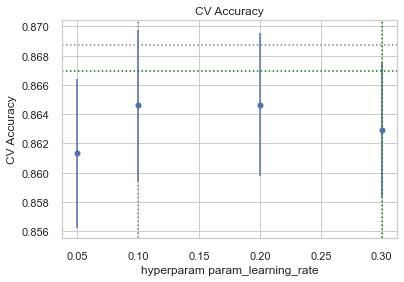

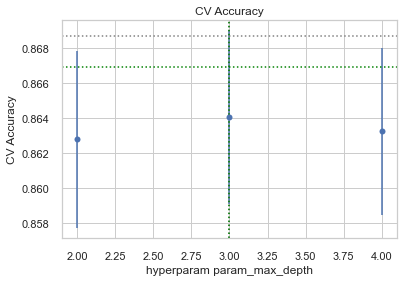

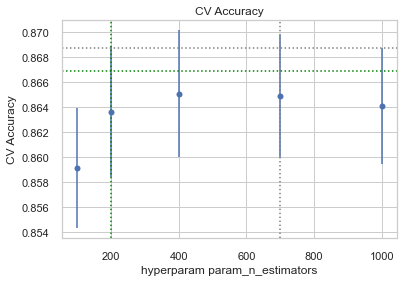

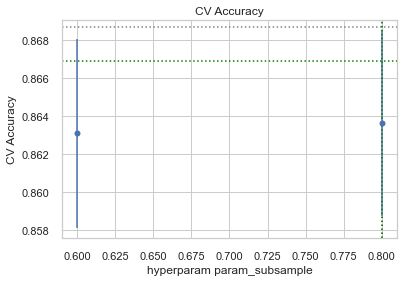

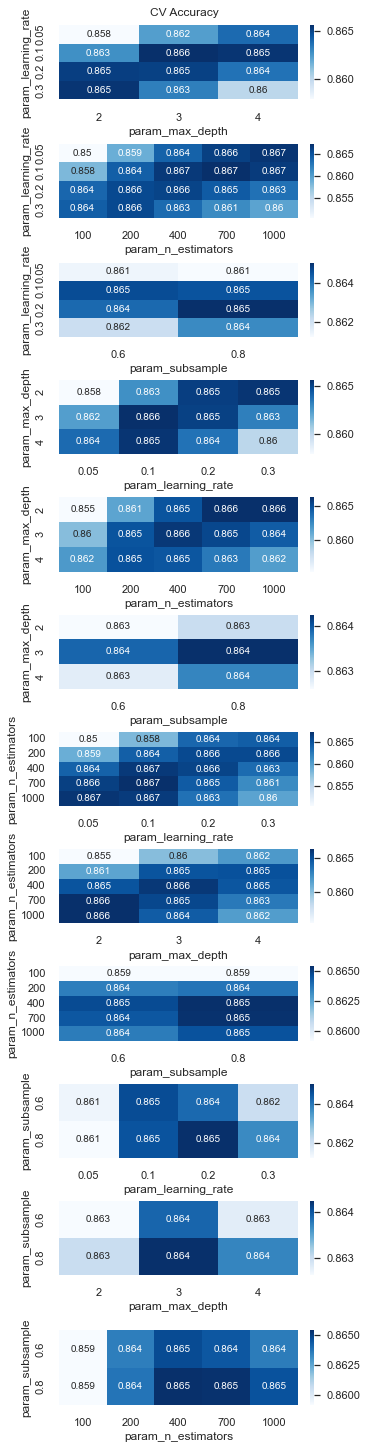

In [62]:
if perform_CV_bool:
        params_XGB = perform_CV(X_train_transformed,y_train,XGB_model,{
        "learning_rate": [0.05,0.1, 0.2, 0.3],"max_depth": [2,3,4],"subsample": [0.6,0.8],"n_estimators": [100,200,400,700,1000]},
        load_bool,save_bool,n_splits=4,se_rule=0,seed=seed)
else:
        params_XGB = joblib.load("params_"+str(type(XGB_model))[8:11]+".json")

The heatmaps display the mean accuracy of one hyperparameter against another. They show that the hyperparameters are not independant one to another.

### 3. Fit the model with selected hyperparameters

For the fitting we use `eval_set`,  to be able to see the evolution of the log-loss  and the classification error across epochs. We also set `EarlyStopping_rounds` to avoid overfitting.

In [63]:
if load_bool: # Load the model already fitted
    XGB_model.load_model("XGB.json")   
else: # or perform fitting with the selected hyperparameters
    XGB_model.set_params(**params_XGB)
    XGB_model.fit(X_train_transformed, y_train,eval_set=[(X_train_transformed, y_train), (X_test_transformed, y_test)], verbose = 0,early_stopping_rounds=20)
if save_bool:
    XGB_model.save_model("XGB.json")

### 4. Diagnostic of the fitted model
Elements of the model diagnostic:

- The accuracy of the training and test set and the absolute error.
- Plots of the log-loss and classification error cross epoch.
- Confusion matrix
- Classification report
- ROC curves

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Accuracy on training: 0.8241003571101547
 Accuracy on test: 0.8274125618018678


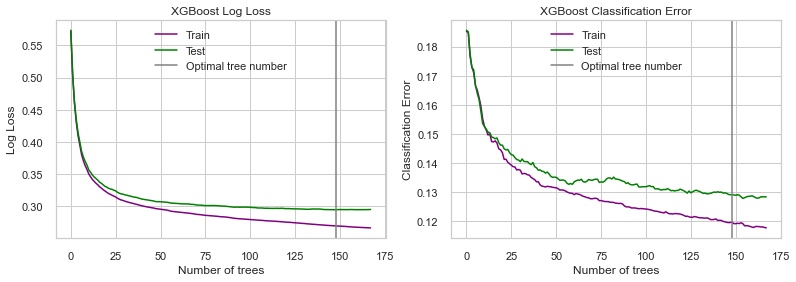

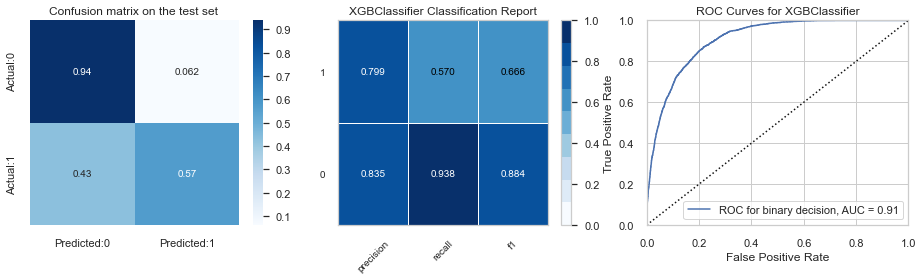

In [64]:
# Predict on training set
y_pred_train_XGB = XGB_model.predict(X_train_transformed,ntree_limit=XGB_model.best_ntree_limit)
acc_train_XBG = accuracy_score(y_train, y_pred_train_XGB)
print("Accuracy on training:", acc_train_XBG)
y_pred_train_diff_XGB = np.abs(y_pred_train_XGB - y_train)

# Predict on test set
y_pred_test_XGB = XGB_model.predict(X_test_transformed,ntree_limit=XGB_model.best_ntree_limit)
acc_test_XGB = accuracy_score(y_test, y_pred_test_XGB)
print(" Accuracy on test:", acc_test_XGB)
y_pred_test_diff_XGB = np.abs( y_pred_test_XGB - y_test)

results = XGB_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot: log loss
fig1, ax = plt.subplots(1,2,figsize=(13, 4))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train', color = "purple")
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test', color = "green")
ax[0].axvline(XGB_model.best_ntree_limit, color="gray", label="Optimal tree number")
ax[0].legend(loc='best')
ax[0].set_ylabel('Log Loss')
ax[0].set_xlabel("Number of trees")
ax[0].set_title('XGBoost Log Loss')

# Plot: classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train',color = "purple")
ax[1].plot(x_axis, results['validation_1']['error'], label='Test',color = "green")
ax[1].axvline(XGB_model.best_ntree_limit, color="gray", label="Optimal tree number")
ax[1].legend(loc = 'best')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel("Number of trees")
ax[1].set_title('XGBoost Classification Error')

# Plot: classification report and ROCAUC
fig2, ax = plt.subplots(1,3,figsize=(13, 4))

visualgrid = [ClassificationReport(XGB_model, ax=ax[1],cmap="Blues"),
              ROCAUC(XGB_model, ax=ax[2], binary=True),]
for viz in visualgrid:
    viz.fit(X_train_transformed, y_train)
    viz.score(X_test_transformed, y_test)
    viz.finalize()
    
# Plot: confusion matrix
cm = confusion_matrix(y_test, y_pred_test_XGB, normalize="true")
conf_matrix = pd.DataFrame(
    data=cm, columns=["Predicted:0", "Predicted:1"], index=["Actual:0", "Actual:1"])
sns.heatmap(conf_matrix, annot=True, cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion matrix on the test set ")
plt.show()

if save_bool:
    fig1.savefig("diagnostic1_XGB.jpg")
    fig2.savefig("diagnostic2_XGB.jpg")

Note: 

- The log-loss on training and test are very similar, meaning that the model can generalize well.
- In the confusion matrix, the percentage of successful predictions is way higher when it comes to the “0” prediction. This is related to the large number of “0” in the y.
- The ROC curve is close to the top-left corner: this  indicates good performance.

### 5. k-fold cross-validation on the validation set to address the accuracy of the model

In [65]:
resum_XGB = cross_val_score(XGB_model, X_val_transformed, y_val, cv=kfold, scoring="accuracy",n_jobs=-1) 
print("Mean accuracy of the XGradient Boosting computed on "+str(n_splits)+ "-fold:  " + str( resum_XGB.mean())+ "  (" + str(resum_XGB.std()) + ")" )

Mean accuracy of the XGradient Boosting computed on 6-fold:  0.8643113110576044  (0.007955430325467428)


## 2. Neural Network 

### 1. Preprocessing 

Here we don’t set the model into the pipeline since  the parameter `validation_data`, used to plot the diagnostic of the neural network, is not supported.

In [66]:
_, X_train_transformed_NN, X_test_transformed_NN,X_val_transformed_NN = set_pipe_model(X_train,X_test,X_val,XGB_model,
    numerical_scaler='StandardScaler',  #'MinMaxScaler'
    numerical_imputer='median',        # 'median', 'mean', 'MissForest'
    categorical_encoder='OneHotEncoder', # 'OrdinalEncoder'
    categorical_imputer='most frequent')# 'MissForest', 'nothing'   

### 2. Hyperparameter selection 
To choose the best hyperparameters, we used the function `tuner`(for the sake of conciseness this code is not shown here). 
Neural network models have a lot of parameters to fit, this makes them very likely to overfit. To control overfitting we pay close attention to the number of epochs, the learning rate and the batch size. Also, we set the `EarlyStopping` parameter and introduce a  dropout component at each layer.

In [67]:
activation="relu" #sigmoid
learning_rate=1e-4
epochs = 200
batch_size = 15
drop_out = 0.2
patience = 20

### 3. Fit the model with selected hyperparameters

In [68]:
# Define the model
def model_NN_fct():
    model= keras.models.Sequential(
    [keras.layers.Dense(units=250, activation=activation),
    keras.layers.Dropout(rate=drop_out),
    keras.layers.Dense(units=50, activation=activation),
    keras.layers.Dropout(rate=drop_out),
    keras.layers.Dense(units=2, activation="softmax"),])

    model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate),  #"sgd",# "adam"
    metrics=["accuracy"])
     
    return model

if load_bool:
    NN_model = joblib.load("NN_model.json")
    history = joblib.load("NN_history.json")
else: 
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    # Set the model
    NN_model = model_NN_fct()
    
    # Fit the model
    history = NN_model.fit(X_train_transformed_NN,y_train,
                            validation_data=(X_test_transformed_NN, y_test),
                            epochs=epochs,batch_size=batch_size, callbacks=[early_stopping_cb])
    
if save_bool:
    joblib.dump(NN_model,"NN_model.json")
    joblib.dump(history,"NN_history.json")

INFO:tensorflow:Assets written to: ram://da0fb421-5d15-498f-91cc-178846bb064d/assets
INFO:tensorflow:Assets written to: ram://68b234fd-3778-4b10-b5f3-5829f7047bea/assets


### 4. Diagnostic of the fitted model
Elements of the neural network diagnostic:

- The summary of the network.
- The accuracy of the training and test set and the absolute error.
- By passing `validation_data` as an argument for the fitting we are now able to see the evolution of the accuracy  and loss across epochs.
- The confusion matrix.

Note: we can't use the diagnostic of yellowbrick because it doesn't support keras.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 250)               92000     
                                                                 
 dropout_6 (Dropout)         (None, 250)               0         
                                                                 
 dense_11 (Dense)            (None, 50)                12550     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                 102       
                                                                 
Total params: 104,652
Trainable params: 104,652
Non-trainable params: 0
_________________________________________________________________
None
           OPERATION           DATA DIMENSI

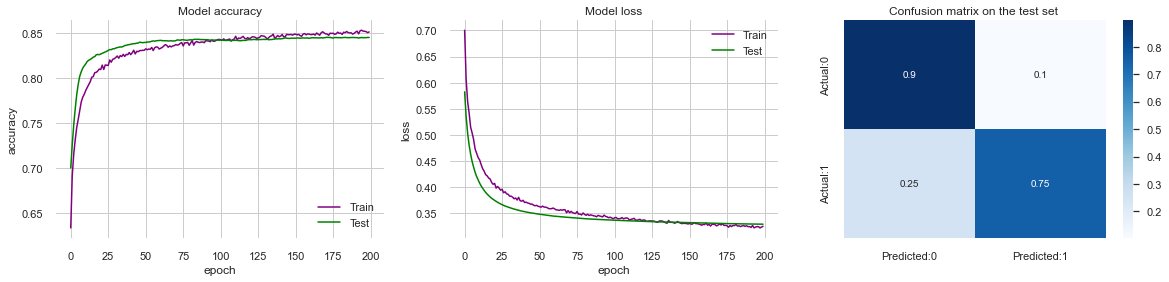

In [69]:
print(NN_model.summary())
keras2ascii(NN_model)

# Predict on training set
y_pred_train_NN = np.argmax(NN_model.predict(X_train_transformed_NN), axis=1)
acc_train_NN = accuracy_score(y_train, y_pred_train_NN)
y_pred_train_diff_NN = np.abs(y_pred_train_NN - y_train)
print("Accuracy on training:", acc_train_NN)

# Predict on test set
y_pred_test_NN = np.argmax(NN_model.predict(X_test_transformed_NN), axis=1)
acc_test_NN = accuracy_score(y_test, y_pred_test_NN)
y_pred_test_diff_NN = np.abs(y_pred_test_NN - y_test)
print("Accuracy on test:", acc_test_NN)
    
# Plot: model accuracy 
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
sns.despine(top=True, left=True, bottom=True)

ax[0].plot(history.history["accuracy"],label='Train',color = "purple")
ax[0].plot(history.history["val_accuracy"],label='Test',color = "green")
ax[0].set_title("Model accuracy")
ax[0].set_ylabel("accuracy")
ax[0].legend( loc="lower right")
ax[0].set_xlabel("epoch")

# Plot: model loss
ax[1].plot(history.history["loss"], label='Train',color = "purple")
ax[1].plot(history.history["val_loss"],label='Test',color = "green")
ax[1].set_title("Model loss")
ax[1].set_ylabel("loss")
ax[1].set_xlabel("epoch")
ax[1].legend( loc="upper right")

# Plot: confusion matrix
cm = confusion_matrix(y_test, y_pred_test_NN, normalize="true")
conf_matrix = pd.DataFrame(data=cm, columns=["Predicted:0", "Predicted:1"], index=["Actual:0", "Actual:1"])
ax[2].set_title("Confusion matrix on the test set ")
sns.heatmap(conf_matrix, annot=True, cmap='Blues', ax=ax[2])

plt.show()

if save_bool:
    fig.savefig("diagnostic_NN.png")

Comments on the results:

- The accuracy of training and test are very similar, meaning that the model can generalize well.
- The accuracy and loss plots confirm this idea: in both cases, the two curves are very close.

### 5. k-fold cross-validation on the validation set to address the accuracy of the model

In [70]:
resum_NN = cross_val_score(KerasClassifier(build_fn=model_NN_fct, epochs=epochs, batch_size=batch_size, verbose=2),
                           X_val_transformed_NN, y_val, cv=kfold, scoring="accuracy",n_jobs=-1) 
print("Mean accuracy of the neural network computed on "
      +str(n_splits)+ "-fold:  " + str( resum_NN.mean())+ "  (" + str(resum_NN.std()) + ")" )

/var/folders/s6/l529vks526z56qt_gfd4n3g40000gn/T/ipykernel_15764/151745727.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  resum_NN = cross_val_score(KerasClassifier(build_fn=model_NN_fct, epochs=epochs, batch_size=batch_size, verbose=2),
2022-05-29 17:09:54.689021: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-29 17:09:54.693302: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

Epoch 1/200
607/607 - 1s - loss: 0.7440 - accuracy: 0.6784 - 1s/epoch - 2ms/step
Epoch 1/200
607/607 - 1s - loss: 1.0986 - accuracy: 0.4518 - 1s/epoch - 2ms/step
Epoch 1/200
607/607 - 1s - loss: 0.7420 - accuracy: 0.6344 - 1s/epoch - 2ms/step
Epoch 1/200
607/607 - 1s - loss: 0.7889 - accuracy: 0.5802 - 1s/epoch - 2ms/step
Epoch 1/200
607/607 - 1s - loss: 0.6837 - accuracy: 0.6472 - 1s/epoch - 2ms/step
Epoch 1/200
607/607 - 1s - loss: 0.8671 - accuracy: 0.4887 - 1s/epoch - 2ms/step
Epoch 2/200
607/607 - 1s - loss: 0.6600 - accuracy: 0.6654 - 1s/epoch - 2ms/step
Epoch 2/200
607/607 - 1s - loss: 0.7910 - accuracy: 0.5943 - 1s/epoch - 2ms/step
Epoch 2/200
607/607 - 1s - loss: 0.6874 - accuracy: 0.6861 - 1s/epoch - 2ms/step
Epoch 2/200
607/607 - 1s - loss: 0.7007 - accuracy: 0.6554 - 1s/epoch - 2ms/step
Epoch 2/200
607/607 - 1s - loss: 0.7304 - accuracy: 0.6230 - 1s/epoch - 2ms/step
Epoch 2/200
607/607 - 1s - loss: 0.7100 - accuracy: 0.6165 - 1s/epoch - 2ms/step
Epoch 3/200
607/607 - 1s - l

# IV. Comparison with other models

Let’s use the functions previously define to set, cross-validate, fit and diagnose the following models:
kNN, LDA, QDA, logistic, SVC linear and RF

_______________________________kNN_______________________________
best.  Score: 0.8119219945280367 Parameters:
{'kNN__n_neighbors': 16}
best 1se. Score: 0.8108230561694096 Parameters:
{'kNN__n_neighbors': 15}
--- 0.04412579536437988 seconds ---


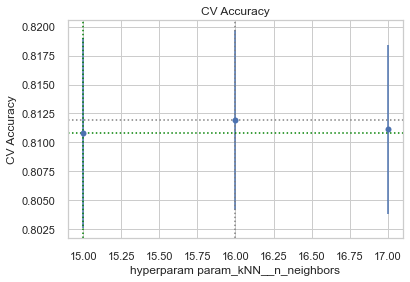

Accuracy on training: 0.8233373012239417
 Accuracy on test: 0.826588536898004


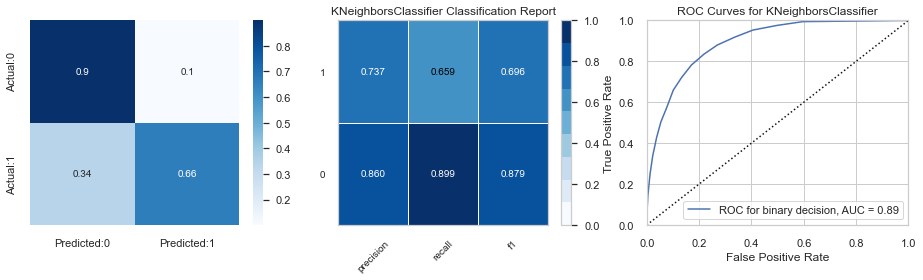

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing kNN, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing kNN, total=   0.0s
Mean accuracy computed on 6-fold:  0.812215292487121  (0.008936447605768866)
_______________________________LDA_______________________________
best.  Score: 0.8505936219546228 Parameters:
{}
best 1se. Score: 0.8505936219546228 Parameters:
{}
--- 0.008967161178588867 seconds ---
Accuracy on training: 0.850776790892165
 Accuracy on test: 0.8495696758835378


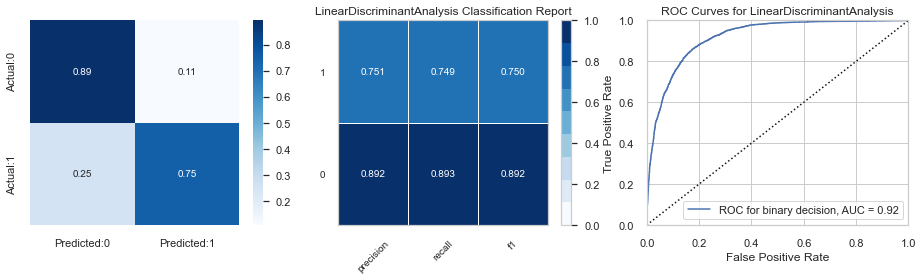

Mean accuracy computed on 6-fold:  0.8508524881671505  (0.007069181123958354)
_______________________________QDA_______________________________
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing kNN, total=   0.0s
best.  Score: 0.6820513938304601 Parameters:
{}
best 1se. Score: 0.6820513938304601 Parameters:
{}
--- 0.011673927307128906 seconds ---
Accuracy on training: 0.6741446143515551
 Accuracy on test: 0.659403039736312


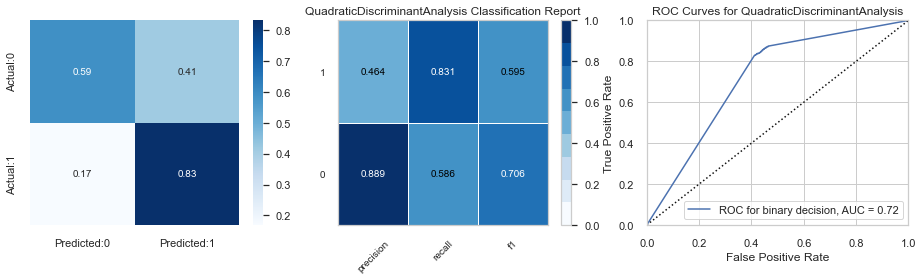

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables ar

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing QDA, total=   1.0s
Mean accuracy computed on 6-fold:  0.6761592974113567  (0.021145867219836446)
_______________________________logistic_______________________________
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing kNN, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing LDA, total=   1.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing QDA, total=   1.0s
best.  Score: 0.8441838499208044 Parameters:
{'logistic__C': 0.31622776601683794}
best 1se. Score: 0.8436039209154863 Parameters:
{'logistic__C': 0.01}
--- 0.007131338119506836 seconds ---


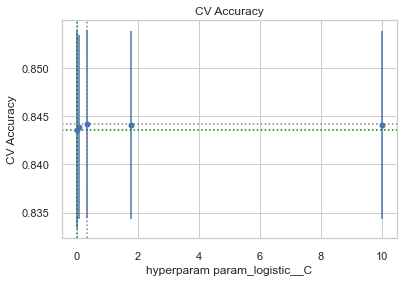

Accuracy on training: 0.8493117235906358
 Accuracy on test: 0.8467313678813404


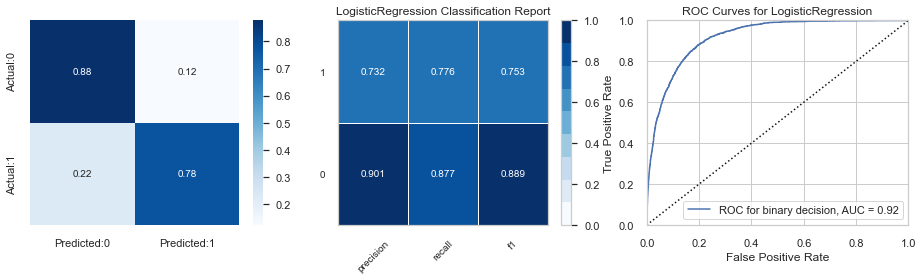

Mean accuracy computed on 6-fold:  0.8353800693174663  (0.012727915023398121)
_______________________________SVC_linear_______________________________
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing kNN, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing LDA, total=   1.1s
best.  Score: 0.8505023822005817 Parameters:
{'SVC_linear__C': 0.1}
best 1se. Score: 0.8505023822005817 Parameters:
{'SVC_linear__C': 0.1}
--- 0.008877992630004883 seconds ---


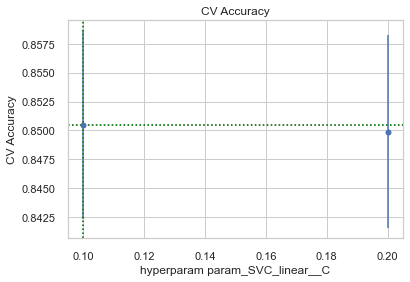

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing logistic, total=   0.1s
Accuracy on training: 0.8545920703232305
 Accuracy on test: 0.8554294085332357


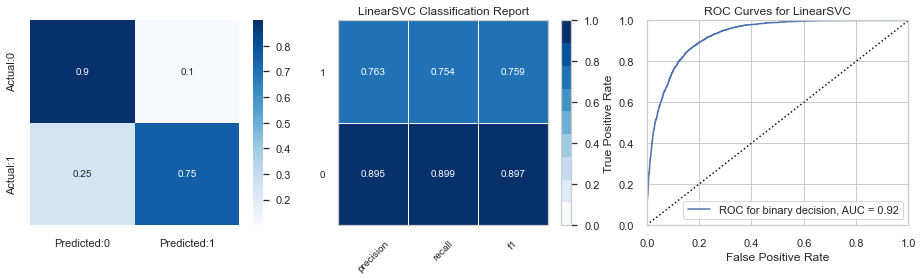

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Li

Mean accuracy computed on 6-fold:  0.8487469650978712  (0.008076988930632379)
_______________________________RF_______________________________
best.  Score: 0.8588652688623726 Parameters:
{}
best 1se. Score: 0.8588652688623726 Parameters:
{}
--- 0.7610359191894531 seconds ---
Accuracy on training: 0.9170100418154625
 Accuracy on test: 0.9146676432887749


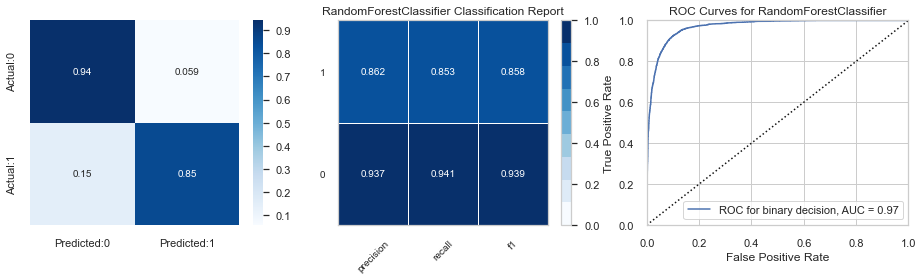

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing SVC_linear, total=   6.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing kNN, total=   0.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing LDA, total=   1.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing QDA, total=   1.0s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] .......... (step 2 of 2) Processing logistic, total=   0.1s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ........ (step 2 of 2) Processing SVC_linear, total=   6.4s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.2s
[Pipeline] ................ (step 2 of 2) Processing RF, total=12.7min
[Pipel

In [71]:
MODELS = [
    ("kNN", KNeighborsClassifier(n_neighbors=15)),
    ("LDA",LinearDiscriminantAnalysis()),
    ("QDA",QuadraticDiscriminantAnalysis(store_covariance=True)),
    ("logistic",LogisticRegression(C=0.2, penalty="l1", solver="saga", tol=0.1, random_state=seed)),
    ("SVC_linear", LinearSVC(C=0.1, loss="squared_hinge", penalty="l2")),
    ("RF",RandomForestClassifier(n_estimators=1300,warm_start=False,oob_score=True, random_state=seed, n_jobs=-1,
                                        bootstrap= True,max_depth= 25, max_features= 37, min_samples_split= 5, verbose = False)),]
    

HYPER_PARAMS = [ {"kNN__n_neighbors": [15, 16, 17]},{},{},
    {"logistic__C": 10 ** np.linspace(-2, 1, 5)},
    {"SVC_linear__C": [0.1, 0.2]},
    {"RF__max_features": [ 39, 40]},]

# Initialization
NAME_MODELS = [MODELS[i][0] for i in range(len(MODELS))]
NAME_MODELS = NAME_MODELS + ["XGB", "NN"]
nb_models = len(NAME_MODELS)
PARAMS = []
Y_PRED_TRAIN = np.empty((len(y_train),nb_models))
ACC_TRAIN = np.empty((1,nb_models))
Y_PRED_TEST = np.empty((len(y_test),nb_models))
ACC_TEST = np.empty((1,nb_models))
RESUM_CV = np.empty((n_splits,nb_models))

# Store the result of XGB and NN 
PARAMS.append(params_XGB)
Y_PRED_TRAIN[:,-2] = y_pred_train_diff_XGB
ACC_TRAIN[0,-2] = acc_train_XBG
Y_PRED_TEST[:,-2] = y_pred_test_diff_XGB
ACC_TEST[0,-2] = acc_test_XGB
RESUM_CV[:,nb_models-2] = resum_XGB

Y_PRED_TRAIN[:,-1] = y_pred_train_diff_NN
ACC_TRAIN[0,-1] = acc_train_NN
Y_PRED_TEST[:,-1] = y_pred_test_diff_NN
ACC_TEST[0,-1] = acc_test_NN
RESUM_CV[:,-1] = resum_NN

for idx in range(0,nb_models-2):
    print("_______________________________" + NAME_MODELS[idx]+"_______________________________")
    
    # 1. Preprocessing, 2. Hyperparameter selection with CV, 3. Fit the model with selected hyperparameters
    fitted_model,params  = model_pip_cv_fit(X_train, y_train,X_test, y_test,MODELS[idx] ,
                           HYPER_PARAMS[idx],load_bool,perform_CV_bool,save_bool, 
                           numerical_scaler='StandardScaler',numerical_imputer='median',
                           categorical_encoder='OneHotEncoder', categorical_imputer='most frequent')
    PARAMS.append(params)
    
    #4. Diagnostic of the fitted model
    Y_PRED_TRAIN[:,idx], ACC_TRAIN[0,idx], Y_PRED_TEST[:,idx], ACC_TEST[0,idx] = model_diagnostic(X_train, y_train, X_test, y_test, fitted_model)
    
    
    # 5. k-fold cross validation on the validation set to address accuracy of the model
    RESUM_CV[:,idx] = cross_val_score(fitted_model, X_val, y_val, cv=kfold, scoring="accuracy",n_jobs=-1).tolist()
    print("Mean accuracy computed on "+str(n_splits)+ "-fold:  " + str( RESUM_CV[:,idx].mean())+ "  (" + str(RESUM_CV[:,idx].std()) + ")" )

## Comparative plots

The best hyperparameters for each model according to the cross validation method are: [{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700, 'subsample': 0.8}, {'kNN__n_neighbors': 16}, {}, {}, {'logistic__C': 0.31622776601683794}, {'SVC_linear__C': 0.1}, {}]


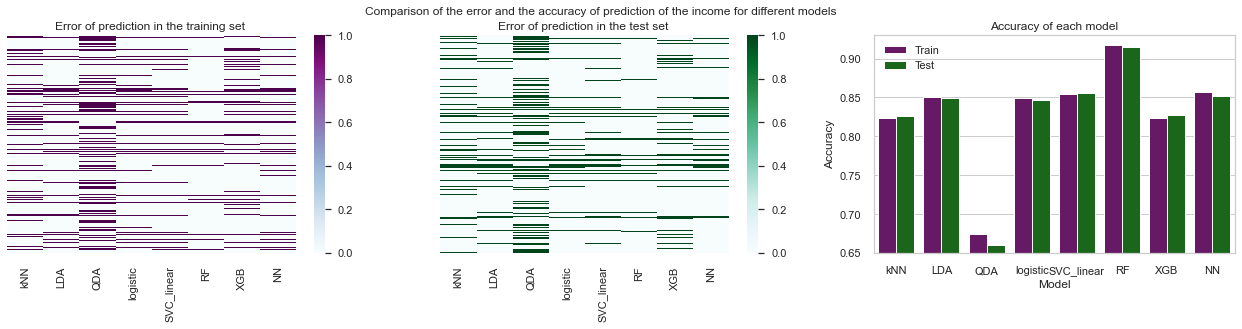

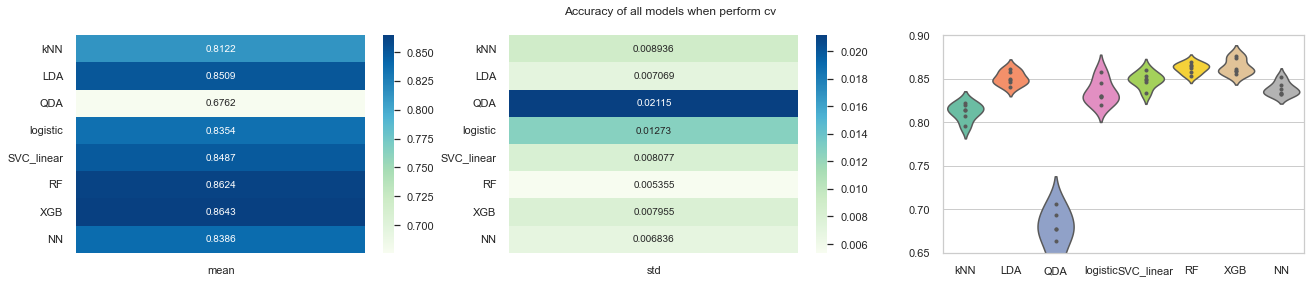

In [84]:
print("The best hyperparameters for each model according to the cross validation method are:",PARAMS)
ACC= pd.DataFrame({"Model":NAME_MODELS,"Train": np.squeeze(ACC_TRAIN), "Test":  np.squeeze(ACC_TEST)})
ACC = pd.melt(ACC, id_vars="Model", var_name="data type", value_name="Accuracy")

fig1, ax = plt.subplots(1,3,figsize=(22, 4))
fig1.suptitle('Comparison of the error and the accuracy of prediction of the income for different models')

ax[0].set_title('Error of prediction in the training set ')
sns.heatmap(ax = ax[0],data =Y_PRED_TRAIN, xticklabels=NAME_MODELS, yticklabels='', cmap = 'BuPu')

ax[1].set_title('Error of prediction in the test set ')
sns.heatmap(ax=ax[1],data = Y_PRED_TEST,xticklabels=NAME_MODELS, yticklabels='', cmap = 'BuGn')

ax[2].set_title('Accuracy of each model')
ax[2].set(ylim=(0.65,0.93))

sns.barplot(ax=ax[2],x='Model', y='Accuracy', hue='data type', data=ACC, palette = sns.set_palette(["purple","green"]), saturation = 0.6)
plt.legend(loc='upper left')


fig2, ax = plt.subplots(1,3,figsize=(22, 4))
fig2.suptitle('Accuracy of all models when perform cv')
ax[0].set_title('')
sns.heatmap(ax = ax[0],data =np.array([RESUM_CV.mean(axis=0)]).T, xticklabels=['mean'], yticklabels=NAME_MODELS, cmap= "GnBu",annot=True, fmt='.4g')
ax[1].set_title('')
sns.heatmap(ax = ax[1],data =np.array([RESUM_CV.std(axis=0)]).T, xticklabels=['std'], yticklabels=NAME_MODELS, cmap= "GnBu",annot=True, fmt='.4g')
ax[2].set_title('')
sns.violinplot( data=pd.DataFrame(RESUM_CV, columns= NAME_MODELS), palette="Set2", inner="point", scale ="count",scale_hue=True, bw=.7, saturation = 0.9)
ax[2].set(ylim=(0.65,0.90))

if save_bool:
    joblib.dump(PARAMS, "resum_best_param.pkl")
    joblib.dump(ACC, "resum_accuracy_train_test.pkl")
    joblib.dump(RESUM_CV, "resum_accuracy_CV.pkl")
    fig1.savefig("prediction_train_test.jpg")
    fig2.savefig("accuracy_CV.jpg")

To compare the models all together we display the following plots:

- The first heatmaps of the absolute difference between the real observations and the predicted ones for each model on the training set (left) and test set (right) . White space means well predict.  These plots allow us to have a visual impression of the performance of each model.
     - Note that for some observations almost all models perform poorly. It can be very interesting to look into this observation. Is there a lot of missing values ?  Do these observations have anything in common?  Such analysis can be very useful when it comes to improve the preprocessing or the model performance.

- The bar plot shows the accuracy of the train and set for each model.
- The heatmaps of the second row show the  mean and standard deviation of the accuracy of all models when cross-validation is performed.
- The violin plots show the distribution of the accuracy for each model when cross-validation is performed.

### Comments
- Interestingly enough, simple linear model as LDA and SVC linear perform quite well.
- QDA is not working well because it is very sensitive to the multicollinearity between the variables.
- Random forest has the highest accuracy for the train and test set. However, its cross-validation accuracy is  not as high. This model  is not able to generalize well enough. This can be due to overfitting during the hyperparameter selection. ( since the test accuracy is almost the same as the train one )
- On the train and test set XGradient Boosting has a quite low performance, but when performing cross-validation its accuracy is the highest. This model generalizes very well.

# V. Conclusion and kaggle soumission

In this dataset, the challenge was to deal with a large number of missing values as well as categorical features. After having tested several preprocessing and models, we decided to choose a model that can handle nan and  use `pd.get_dummies` on the concatenate predictors data to transform the categorical variables. 

The model chosen is  "XGradient Boosting".  After the selection of the best hyperparameters with cross validation, we addressed the performance. To do so we computed the accuracy  of the training, test and validation set, and compare with other models. It comes out that on the validation test XGB has the best mean accuracy. We choosed this model for the Kaggle soumission.

In [74]:
# Transform the test data
_, X_train_transformed, X_test_data_transformed,X_val_transformed = set_pipe_model(X_train,X_test_data,X_val,XGB_model,
    numerical_scaler='StandardScaler',
    numerical_imputer='nothing',
    categorical_encoder='OneHotEncoder',
    categorical_imputer='most frequent')

# Predict 
y_pred_test = XGB_model.predict(X_test_data_transformed,ntree_limit=XGB_model.best_ntree_limit)
y_pred = pd.DataFrame({"high_income": y_pred_test})
y_pred = pd.concat([X_test_data["id"], y_pred], axis=1)

#Save
y_pred.to_csv("y_0_05_4_1000_0_6.csv", index=False)

/opt/anaconda3/envs/ML/lib/python3.9/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [75]:
y_pred.dtypes
y_pred.head()

,id,high_income
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# Annex

In this section, we put the "Staking classifier" model as an interesting approach to predicting. It consists of an ensemble machine learning algorithm that learns how to best combine the predictions from multiple well-performing machine learning models. Hence it makes predictions that have better performance than any single model in the ensemble. Here we try a stacking model with two estimators “XGB” and “RF”. As a final estimator, we use logistic regression. After preprocessing the data (omitted in this section) and running the stacking script, we get an overfitted model (see results below). Here it could be interesting if we could use several combinations of models.

In [86]:
"""
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

estimators = [
("RF",RandomForestClassifier(n_estimators=1300,warm_start=False,oob_score=True, random_state=seed, n_jobs=-1,
bootstrap= True,max_depth= 27, max_features= 37, min_samples_split= 6, verbose = False)),
('xgb', make_pipeline(StandardScaler(), XGBClassifier(objective='binary:logistic',n_estimators=1200,learning_rate=0.1,max_depth=2,
subsample = 0.8, tree_method= "hist",eval_metric=["error", "logloss"] ) ))
]
clf = StackingClassifier(cv=10,
estimators=estimators,n_jobs=-1, final_estimator=LogisticRegression())


clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(" Accuracy on train for the model poly:", acc_train)
print(" Accuracy on test for the model poly:", acc_test)
"""

'\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.ensemble import StackingClassifier\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier\nimport xgboost as xgb\nfrom xgboost import XGBClassifier\n\nestimators = [\n("RF",RandomForestClassifier(n_estimators=1300,warm_start=False,oob_score=True, random_state=seed, n_jobs=-1,\nbootstrap= True,max_depth= 27, max_features= 37, min_samples_split= 6, verbose = False)),\n(\'xgb\', make_pipeline(StandardScaler(), XGBClassifier(objective=\'binary:logistic\',n_estimators=1200,learning_rate=0.1,max_depth=2,\nsubsample = 0.8, tree_method= "hist",eval_metric=["error", "logloss"] ) ))\n]\nclf = StackingClassifier(cv=10,\nestimators=estimators,n_jobs=-1, final_estimator=LogisticRegression())\n\n\nclf.fit(X_train, y_train)\n\ny_pred_train = clf.predict(X_train)\ny_pred_test = clf.predict(X_test)\n\nacc_train = accuracy_score(y_train, y_pred_train)\nacc_test = acc

In [87]:
"""
Accuracy on train for the model stacking: 0.9509671511960627
Accuracy on test for the model stacking: 0.9221754257462004
"""

'\nAccuracy on train for the model stacking: 0.9509671511960627\nAccuracy on test for the model stacking: 0.9221754257462004\n'